In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.storagelevel import StorageLevel

In [40]:
spark = SparkSession.builder.appName("Music") \
    .getOrCreate()
df = spark.read.csv("output.csv", header=True)
df = df.dropna()

In [3]:
columns_to_cast = ["Acousticness", "Energy", "Liveness", "Loudness", "Tempo", "Popularity"]
for col_name in columns_to_cast:
    df = df.withColumn(col_name, col(col_name).cast("double"))

In [4]:
indexer = StringIndexer(inputCol="Explicit", outputCol="ExplicitIndex")
df = indexer.fit(df).transform(df)
assembler = VectorAssembler(
    inputCols=["Acousticness", "Energy", "Liveness", "Loudness", "Tempo", "ExplicitIndex"],
    outputCol="features",
    handleInvalid="skip"
)
df = assembler.transform(df)

In [5]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
df = scaler.fit(df).transform(df)

In [6]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [7]:
kmeans = KMeans(featuresCol="scaledFeatures", k=3)
kmeans_model = kmeans.fit(df)
predictions = kmeans_model.transform(df)

In [27]:
silhouette_scores = []
for k in range(2, 12):
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=42)
    kmeans_model = kmeans.fit(df)
    
    predictions = kmeans_model.transform(df)
    
    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette_score = evaluator.evaluate(predictions)
    
    silhouette_scores.append((k, silhouette_score))
best_k, best_score = max(silhouette_scores, key=lambda x: x[1])

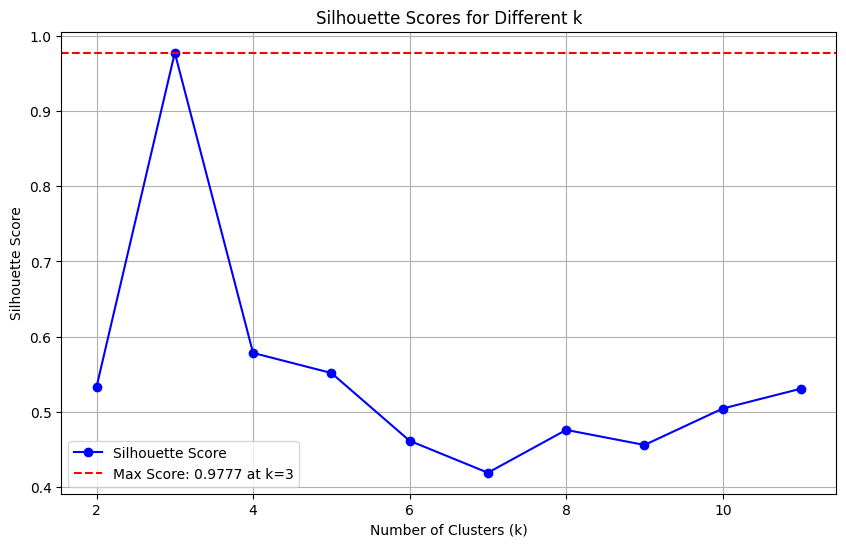

In [28]:
import matplotlib.pyplot as plt
k_values, scores = zip(*silhouette_scores)
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o', linestyle='-', color='b', label="Silhouette Score")
plt.axhline(y=max(scores), color='r', linestyle='--', label=f"Max Score: {max(scores):.4f} at k={k_values[scores.index(max(scores))]}")
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid()
plt.show()

In [29]:
kmeans = KMeans(featuresCol="scaledFeatures", k=best_k, seed=42)
kmeans_model = kmeans.fit(df)
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", metricName="silhouette", distanceMeasure="squaredEuclidean")
predictions = kmeans_model.transform(df)
score = evaluator.evaluate(predictions)


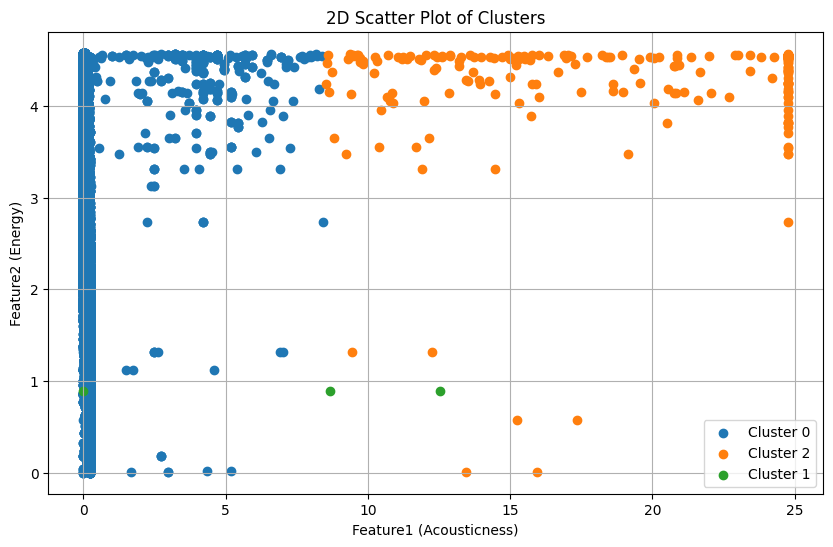

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

small_df = predictions.limit(60000)  # Lấy mẫu 10,000 bản ghi
pandas_df = small_df.select("scaledFeatures", "prediction").toPandas()

# Giải mã `scaledFeatures` thành các giá trị riêng lẻ
scaled_features = pandas_df["scaledFeatures"].apply(lambda x: x.toArray())
scaled_features_df = pd.DataFrame(scaled_features.tolist(), columns=["Feature1", "Feature2", "Feature3", "Feature4", "Feature5", "Feature6"])

# Thêm cột dự đoán (cluster)
scaled_features_df["Cluster"] = pandas_df["prediction"]

# Plot 2D scatter plot (Feature1 và Feature2)
plt.figure(figsize=(10, 6))
for cluster in scaled_features_df["Cluster"].unique():
    cluster_data = scaled_features_df[scaled_features_df["Cluster"] == cluster]
    plt.scatter(cluster_data["Feature1"], cluster_data["Feature2"], label=f"Cluster {cluster}")

plt.title("2D Scatter Plot of Clusters")
plt.xlabel("Feature1 (Acousticness)")
plt.ylabel("Feature2 (Energy)")
plt.legend()
plt.grid()
plt.show()


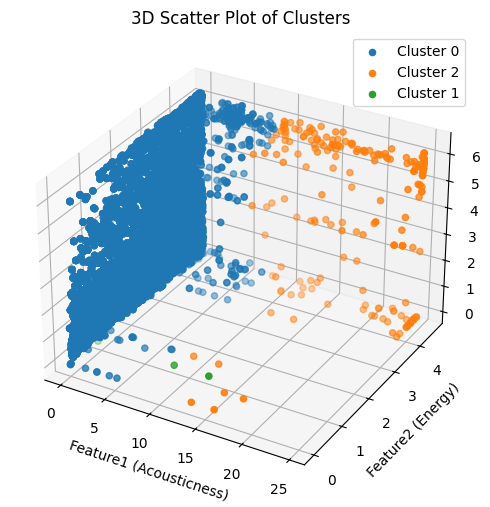

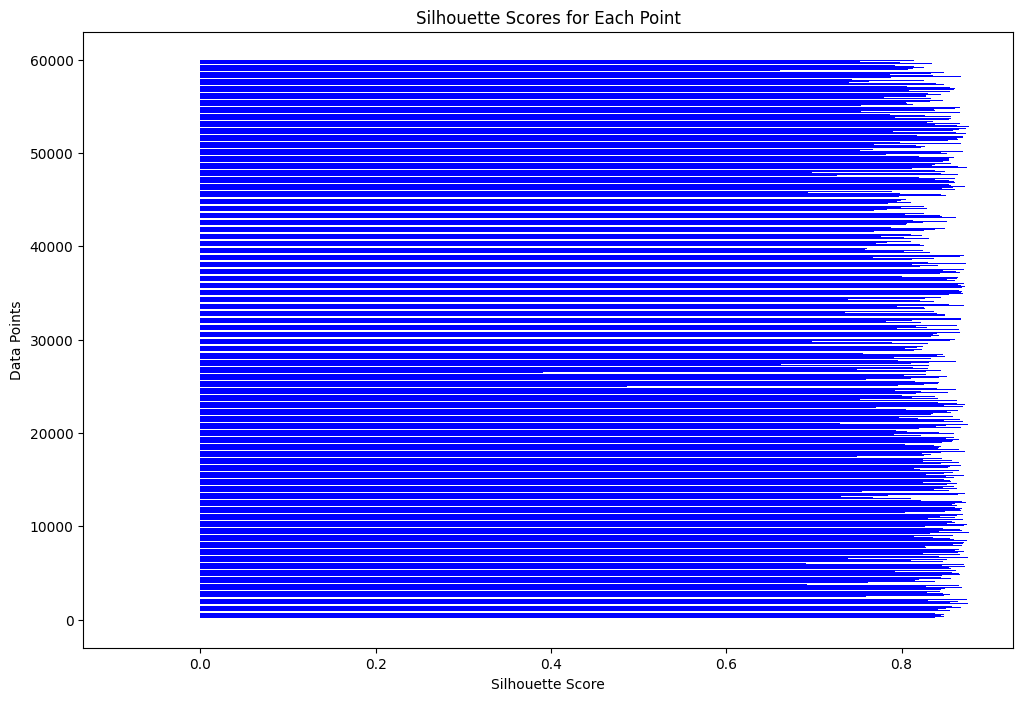

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import pandas as pd

# 3D Scatter Plot of Clusters
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster in scaled_features_df["Cluster"].unique():
    cluster_data = scaled_features_df[scaled_features_df["Cluster"] == cluster]
    ax.scatter(cluster_data["Feature1"], cluster_data["Feature2"], cluster_data["Feature3"], label=f"Cluster {cluster}")

ax.set_title("3D Scatter Plot of Clusters")
ax.set_xlabel("Feature1 (Acousticness)")
ax.set_ylabel("Feature2 (Energy)")
ax.set_zlabel("Feature3 (Liveness)")
ax.legend()
plt.show()

# Silhouette Scores for Each Point
# Tính silhouette scores
scaled_features = scaled_features_df[["Feature1", "Feature2", "Feature3", "Feature4", "Feature5", "Feature6"]].values
silhouette_scores = silhouette_samples(scaled_features, scaled_features_df["Cluster"])

# Tạo DataFrame silhouette
silhouette_df = pd.DataFrame({
    "Cluster": scaled_features_df["Cluster"],
    "Silhouette Score": silhouette_scores
})

# Vẽ biểu đồ silhouette
plt.figure(figsize=(12, 8))
plt.barh(range(len(silhouette_df)), silhouette_df["Silhouette Score"], color='blue')
plt.title("Silhouette Scores for Each Point")
plt.xlabel("Silhouette Score")
plt.ylabel("Data Points")
plt.show()
